# Foundations & Error Analysis

## Imports

In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
import struct

## Finding the Machine Epsilon

Computers cannot store infinite precision. They use Floating Point Arithmetic (usually IEEE 754 standard).
- Machine Epsilon ($\epsilon$): The smallest number such that $1.0 + \epsilon \neq 1.0$. It defines the upper bound on the relative error due to rounding.
- Round-off Error: Caused by the finite precision of computer storage.
- Truncation Error: Caused by approximating an infinite process (like a limit or series) with a finite one.

In [11]:
# Using Numpy
print(f'Machine Epsilon: {np.finfo(float).eps}')

Machine Epsilon: 2.220446049250313e-16


In [12]:
# Manual
eps = 1.0
while 1.0 + eps != 1.0:
    eps /= 2.0
eps *= 2.0

print(f'Calculated Epsilon: {eps}')

Calculated Epsilon: 2.220446049250313e-16


## Binary Representation of Random Numbers (Exam)

We will generate random numbers and inspect their raw bits in the form of Sign, Exponent and Mantissa or Fraction.

In [51]:
def float_to_bin(number):
    # Pack the float into 64 bits (8 bytes)
    packed = struct.pack('!d', number)
    # Unpack as integers to get bits
    integers = [c for c in packed]
    bin_str = ''.join(f'{c:08b}' for c in integers)
    
    # S = 1 bit, E = 11 bits, M = 52 bits
    sign = bin_str[0]
    exponent = bin_str[1:12]
    mantissa = bin_str[12:]
    return sign, exponent, mantissa

random_nums = np.random.uniform(0, 1, 5)

print(f'Number :: Sign -> Exponent -> Mantissa (First 20 Bits)')

for each in random_nums:
    sign, exponent, mantissa = float_to_bin(each)
    print(f'{each} :: {sign} -> {exponent} -> {mantissa[:20]}')

Number :: Sign -> Exponent -> Mantissa (First 20 Bits)
-----------------------------------------------------------------
0.22699326636298955 :: 0 -> 01111111100 -> 11010000111000011101
0.8736891587622444 :: 0 -> 01111111110 -> 10111111010101000010
0.166518954062291 :: 0 -> 01111111100 -> 01010101000001111110
0.5800386782888044 :: 0 -> 01111111110 -> 00101000111110101101
0.4711073021150419 :: 0 -> 01111111101 -> 11100010011010011111


## Catastrophic Cancellation

This occurs when subtracting two nearly equal numbers, causing a loss of precision.

- Given Function: $\sqrt{x^2 + 1} - x$ 
- Optimized Function: $\frac{1}{\sqrt{x^2~+~1}~+~x}$

In [5]:
def main_func(x):
    return np.sqrt(x**2 + 1) - x

In [6]:
def optimized_func(x):
    return 1 / ((np.sqrt(x**2 + 1) + x))

In [7]:
print(f'Result due to Cancellation: {main_func(1e8)}')
print(f'Result without Cancellation: {optimized_func(1e8)}')

Result due to Cancellation: 0.0
Result without Cancellation: 5e-09


## Truncation Error

Approximating $e^x$ using a finite series: $e^x \approx \sum_{n=0}^{N} \frac{x^n}{n!}$

In [8]:
x = 3
true_value_e = np.exp(x)

In [9]:
errors = []
n_vals = np.arange(15)
for n in n_vals:
    approx_val = sum([(x**i)/math.factorial(i) for i in range(n+1)])
    error = abs(true_value_e - approx_val)
    errors.append(error)

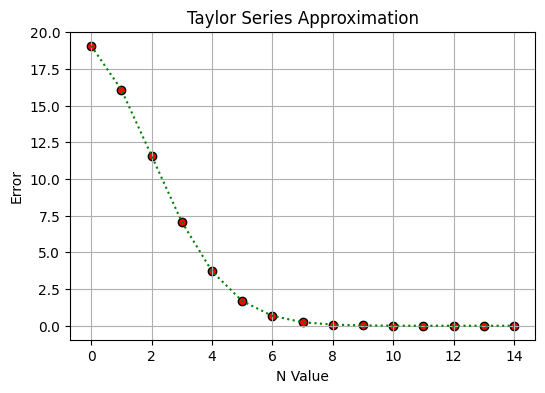

In [10]:
plt.figure(figsize=(6,4))
plt.scatter(n_vals, errors, ec='k', color='red')
plt.plot(n_vals, errors, ls=':', color='green')
plt.xlabel('N Value')
plt.ylabel('Error')
plt.title('Taylor Series Approximation')
plt.grid()
plt.show()

## The Summation Stability Test

We will generate a large dataset (30k numbers) with a wide dynamic range to force round-off errors, then compare summations in different order.

In [325]:
N = 30000
numbers = np.random.uniform(-15, 5, N)
numbers = 10**numbers

random_sum = np.sum(numbers)
print(f'Sum Naive: {random_sum:.15f}')

ascending_sum = np.sum(sorted(numbers))
print(f'Sum Ascending Order: {ascending_sum:.15f}')

descending_sum = np.sum(sorted(numbers, reverse=True))
print(f'Sum Descending Order: {descending_sum:.15f}')

print(f'Error: {abs(descending_sum-ascending_sum):.15f}')

Sum Naive: 63352960.976315587759018
Sum Ascending Order: 63352960.976315602660179
Sum Descending Order: 63352960.976315595209599
Error: 0.000000007450581


## Kahan's Algorithm in Rescue

Kahan Summation introduces a separate variable, let's call it c (for compensation), to remember the tiny bits that were lost in the previous addition. It adds these lost bits back into the next number before adding it to the main sum.

In [330]:
def kahan_sum(numbers):
    sum_val = 0.0
    c = 0.0 
    
    for x in numbers:
        y = x - c         
        t = sum_val + y   
        c = (t - sum_val) - y 
        
        sum_val = t     
        
    return sum_val

large_num = 1.0
tiny_num = 1e-16 
N = 10000

data = np.array([large_num] + [tiny_num] * N)

naive_sum = np.sum(data)
smart_sum = kahan_sum(data)
true_sum = large_num + (tiny_num * N)

print(f"True Sum:      {true_sum:.20f}")
print(f"Naive Sum:     {naive_sum:.20f}")
print(f"Kahan Sum:     {smart_sum:.20f}")

print(f"\nNaive Error:   {abs(true_sum - naive_sum):.20f}")
print(f"Kahan Error:   {abs(true_sum - smart_sum):.20f}")

True Sum:      1.00000000000100008890
Naive Sum:     1.00000000000099853459
Kahan Sum:     1.00000000000100008890

Naive Error:   0.00000000000000155431
Kahan Error:   0.00000000000000000000
